In [79]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import missingno as msno

import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

from src.subjectlist_alignment.impute_null import impute_intubation as ii
from src.subjectlist_alignment import reintubation as rnt

### Reintubationtime Notes
몇 가지 고려사항:
- 삽관/발관 이벤트가 1개 밖에 없는 환자(single event patient)의 경우, 사망 여부 확인이 필요. 
    - 발관 당일 사망 -> 


제외/생략할 데이터
1. 삽관/발관 이벤트가 1개 밖에 없는 환자의 경우 생략 (= no reintubation)
2. extubation 후 24시간 이내 사망한 대상자는 포함하지 않음.



### Code schematic
- 표본 추출을 위한 정확한 기준은 아직 정의되지 않음. 
- 따라서, 발생할 수 있는 다양한 이벤트 케이스를 코드 시스템으로 정의해보고자 함.

### Missing data:
- 테스트 목적이기 때문에 null 결측치는 제외하고 진행함.
- 단, 첫째 행의 null intubationtime 은 admittime으로 대체함.

In [80]:
# 데이터 불러오기
intubation_extubation = pd.read_csv('../outputs/intubation_extubation_modified_240122.csv', index_col=0)
# intubation_extubation2 = pd.read_csv('../outputs/alignment_df_240122_impute.csv', index_col=0)

# 시간변수 바꿔주기
intubation_extubation['intubationtime'] = pd.to_datetime(intubation_extubation['intubationtime'])
intubation_extubation['extubationtime'] = pd.to_datetime(intubation_extubation['extubationtime'])
intubation_extubation['dischtime'] = pd.to_datetime(intubation_extubation['dischtime'])
intubation_extubation['deathtime'] = pd.to_datetime(intubation_extubation['deathtime'])

# intubation_extubation2['intubationtime'] = pd.to_datetime(intubation_extubation2['intubationtime'])
# intubation_extubation2['extubationtime'] = pd.to_datetime(intubation_extubation2['extubationtime'])

# reintubation 재계산 위해 칼럼 삭제
intubation_extubation.drop(columns='reintubationtime', inplace=True)

print(f'dataframe shape: {intubation_extubation.shape}')
# print(f'dataframe shape: {intubation_extubation2.shape}')
# intubation_extubation2.info()

dataframe shape: (9420, 16)


In [81]:
# null 제외
intubation_extubation = intubation_extubation[(intubation_extubation.intubationtime.notna() & intubation_extubation.extubationtime.notna())]

# 정밀한 계산위해 일단은 'unplanned extubation' 제외
intubation_extubation = intubation_extubation[intubation_extubation.extubationcause == 'Planned Extubation']

In [82]:
intubation_extubation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6564 entries, 0 to 9418
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   subject_id        6564 non-null   int64         
 1   hadm_id           6564 non-null   int64         
 2   int_stayid        5761 non-null   float64       
 3   admittime         6564 non-null   object        
 4   intubationtime    6564 non-null   datetime64[ns]
 5   int_itemid        5761 non-null   float64       
 6   int_weight        5761 non-null   float64       
 7   ext_stayid        6564 non-null   float64       
 8   extubationtime    6564 non-null   datetime64[ns]
 9   ext_itemid        6564 non-null   float64       
 10  ext_weight        6564 non-null   float64       
 11  extubationcause   6564 non-null   object        
 12  dischtime         6564 non-null   datetime64[ns]
 13  deathtime         1447 non-null   datetime64[ns]
 14  marker            458 non-nul

In [83]:
grouped_df = intubation_extubation.groupby(['subject_id', 'hadm_id'])

df_list = []
for _, patient_df in grouped_df:
    patient_df = rnt.create_reintubation_column(patient_df)   # reintubationtime 칼럼 초기화
    patient_df = rnt.get_reintubationtime(patient_df)    
    df_list.append(patient_df)

# 환자별 데이터 하나의 데이터프레임으로 합치기
reintubation_df = pd.concat(df_list)

### 환자별 군집화

In [84]:
reintubation_df


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1 days 13:10:00,0.000000
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,3 days 18:19:00,0.000000
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,2 days 17:30:00,0.000000
5,10005817,28661809,31316840.0,2135-01-03 21:54:00,2135-01-06 08:33:00,224385.0,88.8,31316840.0,2135-01-19 14:00:00,227194.0,88.8,Planned Extubation,2135-01-19 18:36:00,2135-01-19 18:36:00,NaN,13 days 05:27:00,0.000000
8,10011365,26712576,37153661.0,2166-02-11 14:09:00,2166-02-14 17:59:00,224385.0,46.3,37153661.0,2166-02-14 09:48:00,227194.0,46.3,Planned Extubation,2166-02-20 00:20:00,2166-02-20 00:20:00,intubationtime later than extubationtime,-1 days +15:49:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9416,19997367,20617667,NaN,2126-04-20 07:15:00,2126-04-20 07:15:00,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,NaN,107.850000
9414,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,5 days 20:16:00,73.833333
9415,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2 days 23:09:00,0.000000
9417,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,2 days 22:01:00,0.000000


In [85]:
reintubation_df.iloc[0].reintubationtime

0.0

In [263]:
# (1분기) single event (no reint) vs multievent (yes reint)
from datetime import timedelta

def get_timediff(n1, n2):
    return n1 - n2

# def get_timediff_disch_lastext(last_row):
#     time_diff = get_timediff(last_row.dischtime, last_row.extubationtime)
#     return time_diff




def classify_reintubation(group):
    subject_id = group.subject_id.unique()
    hadm_id = group.hadm_id.unique()
    id = (subject_id, hadm_id)

    # 분기1: reintubation 여부 확인
    cond_singleevent = (len(group) == 1)   # No: 삽관발관 이벤트가 1개인 경우 (no reintubation) -> 분기 1-1로 이동
    cond_reintubation = (len(group) > 1)   # Yes: 복수의 삽관발관 이벤트가 있는 경우 (reintubation 존재) -> 분기 1-2로 이동

    # # 조건: 재삽관 유무 확인
    # if not cond_reintubation:
    #     return subject_id, hadm_id

    # 분기1-1: 퇴원시간 고려 (reintubation 없는 경우)
    last_row = group.iloc[-1]
    cond_disch_before_48 = get_timediff(last_row.dischtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 퇴원한 경우
    cond_disch_after_48 = get_timediff(last_row.dischtime, last_row.extubationtime) > timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 퇴원한 경우

    # # 조건: 재삽관 없으면서 48시간 이후 퇴원
    # if (not cond_reintubation) & cond_disch_after_48:
    #     return subject_id, hadm_id

    # 분기1-1-1: 사망시간 고려 (reintubation 없는 경우)
    last_row = group.iloc[-1]
    last_extubationtime = last_row.extubationtime
    last_dischtime = last_row.dischtime
    last_deathtime = last_row.deathtime

    cond_death_before_48 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
    cond_death_after_48 = (get_timediff(last_row.deathtime, last_row.extubationtime) > timedelta(hours=48)) | (pd.isna(last_row.deathtime))  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 사망한 경우 (+ 사망시각 없는 경우)
    cond_death = pd.notna(last_row.deathtime)

    # (분기1-1-1-2: 사망시간 24시간 이내 고려)
    cond_death_before_24 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=24)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우

    # if (cond_singleevent) & (cond_disch_before_48) & (cond_death_before_24):  # 발관 후 24시간 이내 사망 케이스
    #     return subject_id, hadm_id
    
    # 분기2: reintubation 횟수 고려
    cond_single_reint = (len(group) == 2)   # reintubation이 1번 이루어진 경우 (2행) -> 분기 2-1-1로 이동
    cond_multi_reint = (len(group) > 2)   # reintubation이 여러번 이루어진 경우 (3행 이상) -> 분기 2-2-1로 이동

    ## 분기2-1: 1번의 reintubation 시행한 케이스: 성공(48시간 이후) 실패(48시간 이내)
    last_reintubationtime = group.iloc[0].reintubationtime  # reintubationtime은 앞의 행에 계산되어 있기 때문에 첫행 가져옴


    cond_last_reint_after48 = last_reintubationtime > 48   # 성공 (reintubationtime 칼럼은 float이기 때문에 time delta 불필요)
    cond_last_reint_before48 = last_reintubationtime <= 48   # 실패

    # 분기2-1-2: 1번의 reintubation 시행 성공 후 사망 케이스 고려 (테스트 중)
    cond_death = not pd.isnull(group.iloc[0].deathtime)    # deathtime이 존재하는지? 사망시간 있으면 true

    # # 조건: 재삽관 여러번 시행
    # if (cond_reintubation) & (cond_multi_reint):
    #     return subject_id, hadm_id
    
    # 조건: 재삽관1회 시행, 48시간 이후 (성공 케이스), 퇴원
    lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
    lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)

    # 발관 성공 후 48시간 이내 사망
    if (cond_reintubation) & (cond_single_reint) & (cond_last_reint_after48) & (lastext_to_disch_time_diff <= timedelta(48)) & (cond_death):
        return subject_id, hadm_id

    # 분기2-2: 여러번의 reintubation 시행한 케이스 
    if cond_reintubation:
        second_last_row = group.iloc[-2]   # 여러번 중 마지막 재삽관 (중요: 마지막 reintubation은 데이터의 n-1 번째 행임. n 번째 행은 0으로 계산됨)
        last_reintubationtime = second_last_row.reintubationtime
        last_extubationtime = group.iloc[-1].extubationtime
        last_dischtime = group.iloc[-1].dischtime
        last_deathtime = group.iloc[-1].deathtime

        cond_last_reint_after48 = last_reintubationtime > 48
        cond_last_reint_before48 = last_reintubationtime <= 48

        # 분기2-2-1: 최종 발관 이후 퇴원 케이스 고려
        lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
        lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)
        cond_disch_before_48 = lastext_to_disch_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 퇴원한 경우
        cond_disch_after_48 = lastext_to_disch_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 퇴원한 경우
        cond_death_before_48 = lastext_to_death_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 사망한 경우
        cond_death_after_48 = lastext_to_death_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 사망한 경우

        # if (cond_reintubation) & (cond_multi_reint) & (cond_last_reint_after48) & (cond_disch_before_48) & (cond_death_before_48):
        #     return subject_id, hadm_id


       # 여러번 중 마지막이 아닌 케이스

    # testing code
    # if cond_reintubation & cond_single_reint & cond_reint_success:   # 총 한번의 삽관발관 이벤트 중 1개가 성공
    #     print(f'subject: {subject_id}, SUCCESS.')
    # elif cond_reintubation & cond_single_reint & cond_reint_failure: # 총 한번의 삽관발관 이벤트 중 1개가 실패
    #     # print(f'subject: {subject_id}, FAILURE.')
    #     pass

    # # testing code
    # if cond_singleevent & cond_disch_after_48:
    #     print(f'id {id}: SINGLE EVENT, DISCH AFTER 48')
    



In [264]:

ids_list = []
total_group_count = 0

reintubation_grouped = reintubation_df.groupby(['subject_id', 'hadm_id'])

for subject, reintubation_group in reintubation_grouped:
    result = classify_reintubation(reintubation_group)
    
    # Check if result is not None or not empty
    if result:
        subject_id, hadm_id = result
        # Check if both subject_id and hadm_id are not empty
        if subject_id and hadm_id:
            ids_list.append((subject_id, hadm_id))
            print(result)
    
    total_group_count += 1

print(f'total group count: {total_group_count}')
print(f'items_included: {len(ids_list)}')



(array([10024982]), array([25154057]))
(array([10119017]), array([20229125]))
(array([10203444]), array([25550068]))
(array([10342123]), array([23603937]))
(array([10357863]), array([25031044]))
(array([10445331]), array([24253259]))
(array([10454567]), array([23632536]))
(array([10533034]), array([20901025]))
(array([10670818]), array([21108661]))
(array([10728002]), array([28666836]))
(array([10760672]), array([29128660]))
(array([10771068]), array([21520079]))
(array([10795507]), array([25606775]))
(array([10813665]), array([26936609]))
(array([10865504]), array([20772091]))
(array([10900129]), array([22036881]))
(array([10980029]), array([22180118]))
(array([11030576]), array([21648828]))
(array([11134447]), array([29068519]))
(array([11182151]), array([22537178]))
(array([11216986]), array([22969970]))
(array([11291823]), array([22586748]))
(array([11356876]), array([24924829]))
(array([11378149]), array([29235017]))
(array([11424506]), array([25745726]))
(array([11576109]), array

In [265]:
total_group_count

5409

In [266]:
len(ids_list)

115

In [267]:
# Assuming ids_list contains your tuples of (subject_id, hadm_id)
subject_ids = [item[0][0] for item in ids_list]  # Extract subject_id from each tuple and create a list
hadm_ids = [item[1][0] for item in ids_list]    # Extract hadm_id from each tuple and create a list

len(subject_ids), len(hadm_ids)

# 한번의 성공적인 reintubation 후 사망한 케이스 필터링
filtered_df = reintubation_df[reintubation_df['subject_id'].isin(subject_ids) & reintubation_df['hadm_id'].isin(hadm_ids)]
filtered_df

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
22,10024982,25154057,NaN,2203-09-19 12:29:00,2203-09-19 12:29:00,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,NaN,90.000000
21,10024982,25154057,37919901.0,2203-09-19 12:29:00,2203-10-02 11:00:00,224385.0,79.1,37919901.0,2203-10-09 14:50:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,7 days 03:50:00,0.000000
91,10119017,20229125,NaN,2159-08-10 23:55:00,2159-08-10 23:55:00,NaN,NaN,31009936.0,2159-08-11 17:12:00,227194.0,59.7,Planned Extubation,2159-08-20 21:40:00,2159-08-20 21:40:00,NaN,NaN,61.433333
90,10119017,20229125,31009936.0,2159-08-10 23:55:00,2159-08-14 06:38:00,224385.0,59.7,31009936.0,2159-08-18 13:38:00,227194.0,59.7,Planned Extubation,2159-08-20 21:40:00,2159-08-20 21:40:00,NaN,4 days 07:00:00,0.000000
163,10203444,25550068,NaN,2134-07-17 13:58:00,2134-07-17 13:58:00,NaN,NaN,37929889.0,2134-07-20 02:30:00,227194.0,62.6,Planned Extubation,2134-08-29 13:34:00,2134-08-29 13:34:00,NaN,NaN,803.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,19732617,22795852,33012121.0,2176-03-01 11:15:00,2176-03-07 15:30:00,224385.0,59.0,33012121.0,2176-03-11 14:10:00,227194.0,59.0,Planned Extubation,2176-03-22 18:10:00,2176-03-22 18:10:00,NaN,3 days 22:40:00,0.000000
9258,19834949,27411859,30913513.0,2179-10-15 13:43:00,2179-10-15 18:40:00,224385.0,101.3,30913513.0,2179-10-21 09:29:00,227194.0,101.3,Planned Extubation,2179-12-07 17:00:00,2179-12-07 17:00:00,NaN,5 days 14:49:00,708.350000
9260,19834949,27411859,39492643.0,2179-10-15 13:43:00,2179-11-19 21:50:00,224385.0,82.9,39492643.0,2179-11-24 18:14:00,227194.0,82.9,Planned Extubation,2179-12-07 17:00:00,2179-12-07 17:00:00,NaN,4 days 20:24:00,0.000000
9307,19872834,22516631,NaN,2139-06-03 14:00:00,2139-06-03 14:00:00,NaN,NaN,30616943.0,2139-06-05 13:30:00,227194.0,80.9,Planned Extubation,2139-06-12 09:42:00,2139-06-12 21:25:00,deathtime later than dischtime,NaN,174.466667


In [170]:
filtered_df.shape

(516, 17)

In [268]:
# 사망시각 - 퇴원시각 계산
filtered_df['death_to_disch'] = filtered_df['dischtime'] - filtered_df['deathtime']

# 사망시각 - 발관시각 계산
filtered_df['ext_to_death'] = filtered_df['deathtime'] - filtered_df['extubationtime']

filtered_df

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_72155/1991077043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['death_to_disch'] = filtered_df['dischtime'] - filtered_df['deathtime']
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_72155/1991077043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ext_to_death'] = filtered_df['deathtime'] - filtered_df['extubationtime']


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime,death_to_disch,ext_to_death
22,10024982,25154057,NaN,2203-09-19 12:29:00,2203-09-19 12:29:00,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,NaN,90.000000,0 days 00:00:00,13 days 02:10:00
21,10024982,25154057,37919901.0,2203-09-19 12:29:00,2203-10-02 11:00:00,224385.0,79.1,37919901.0,2203-10-09 14:50:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,7 days 03:50:00,0.000000,0 days 00:00:00,2 days 04:20:00
91,10119017,20229125,NaN,2159-08-10 23:55:00,2159-08-10 23:55:00,NaN,NaN,31009936.0,2159-08-11 17:12:00,227194.0,59.7,Planned Extubation,2159-08-20 21:40:00,2159-08-20 21:40:00,NaN,NaN,61.433333,0 days 00:00:00,9 days 04:28:00
90,10119017,20229125,31009936.0,2159-08-10 23:55:00,2159-08-14 06:38:00,224385.0,59.7,31009936.0,2159-08-18 13:38:00,227194.0,59.7,Planned Extubation,2159-08-20 21:40:00,2159-08-20 21:40:00,NaN,4 days 07:00:00,0.000000,0 days 00:00:00,2 days 08:02:00
163,10203444,25550068,NaN,2134-07-17 13:58:00,2134-07-17 13:58:00,NaN,NaN,37929889.0,2134-07-20 02:30:00,227194.0,62.6,Planned Extubation,2134-08-29 13:34:00,2134-08-29 13:34:00,NaN,NaN,803.866667,0 days 00:00:00,40 days 11:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,19732617,22795852,33012121.0,2176-03-01 11:15:00,2176-03-07 15:30:00,224385.0,59.0,33012121.0,2176-03-11 14:10:00,227194.0,59.0,Planned Extubation,2176-03-22 18:10:00,2176-03-22 18:10:00,NaN,3 days 22:40:00,0.000000,0 days 00:00:00,11 days 04:00:00
9258,19834949,27411859,30913513.0,2179-10-15 13:43:00,2179-10-15 18:40:00,224385.0,101.3,30913513.0,2179-10-21 09:29:00,227194.0,101.3,Planned Extubation,2179-12-07 17:00:00,2179-12-07 17:00:00,NaN,5 days 14:49:00,708.350000,0 days 00:00:00,47 days 07:31:00
9260,19834949,27411859,39492643.0,2179-10-15 13:43:00,2179-11-19 21:50:00,224385.0,82.9,39492643.0,2179-11-24 18:14:00,227194.0,82.9,Planned Extubation,2179-12-07 17:00:00,2179-12-07 17:00:00,NaN,4 days 20:24:00,0.000000,0 days 00:00:00,12 days 22:46:00
9307,19872834,22516631,NaN,2139-06-03 14:00:00,2139-06-03 14:00:00,NaN,NaN,30616943.0,2139-06-05 13:30:00,227194.0,80.9,Planned Extubation,2139-06-12 09:42:00,2139-06-12 21:25:00,deathtime later than dischtime,NaN,174.466667,-1 days +12:17:00,7 days 07:55:00


In [288]:
ext_to_death_list = []
filter_group = filtered_df.groupby(['subject_id', 'hadm_id'])
for _, group in filter_group:
    idx = len(group) - 1
    last_row = group.iloc[idx]
    minutes = last_row.ext_to_death.total_seconds() / 3600
    ext_to_death_list.append(minutes)


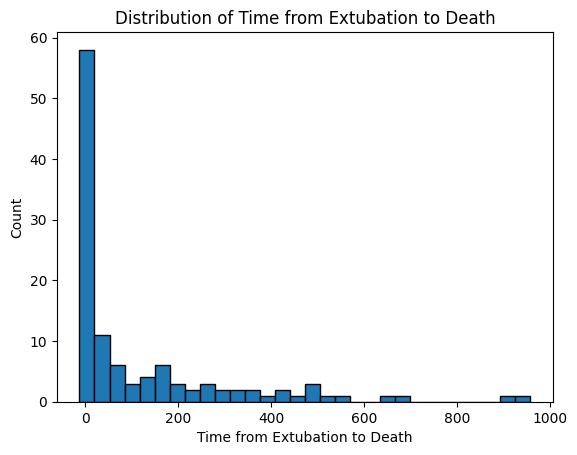

In [289]:
# Assuming ext_to_death_list contains the time differences as numerical values
plt.hist(ext_to_death_list, bins=30, edgecolor='black')
plt.title('Distribution of Time from Extubation to Death')
plt.xlabel('Time from Extubation to Death')
plt.ylabel('Count')
plt.show()

In [291]:
ext_to_death_series = pd.Series(ext_to_death_list)
ext_to_death_series.describe()

count    115.000000
mean     121.259275
std      195.328122
min      -12.833333
25%        1.675000
50%       19.333333
75%      163.016667
max      956.900000
dtype: float64

In [292]:
ext_to_death_series

0       52.333333
1       56.033333
2      120.066667
3       26.466667
4      656.950000
          ...    
110      3.450000
111      7.500000
112    268.000000
113    310.766667
114     -0.250000
Length: 115, dtype: float64

In [302]:
ext_to_death_series[ext_to_death_series > 48].describe()

count     46.000000
mean     292.020652
std      216.213690
min       52.333333
25%      142.566667
50%      238.583333
75%      422.920833
max      956.900000
dtype: float64

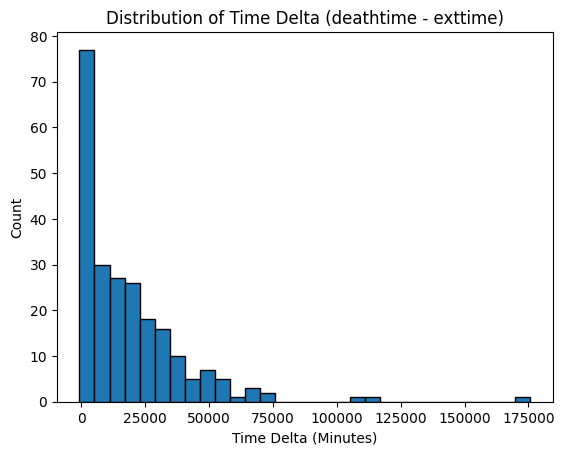

In [269]:
# Convert timedelta to minutes
minutes = filtered_df['ext_to_death'].dropna().dt.total_seconds() / 60

# Plotting the histogram
plt.hist(minutes, edgecolor='black', bins=30)  # Adjust the number of bins as needed
plt.title('Distribution of Time Delta (deathtime - exttime)')
plt.xlabel('Time Delta (Minutes)')
plt.ylabel('Count')
plt.show()

In [271]:
filtered_df['ext_to_death'].describe()

count                           230
mean     12 days 15:28:48.260869565
std      15 days 02:37:48.083004927
min               -1 days +11:10:00
25%                 0 days 20:12:15
50%                 8 days 21:15:00
75%                17 days 21:59:45
max               122 days 00:51:00
Name: ext_to_death, dtype: object

In [217]:
filtered_df['ext_to_death'].mode()

0   0 days 00:30:00
Name: ext_to_death, dtype: timedelta64[ns]

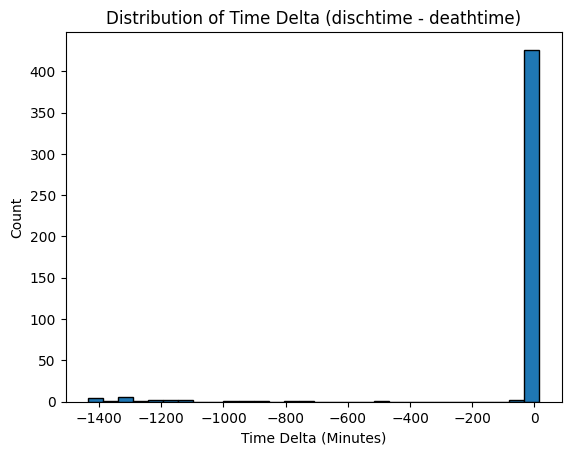

In [213]:
# Convert timedelta to minutes
minutes = filtered_df['death_to_disch'].dropna().dt.total_seconds() / 60

# Plotting the histogram
plt.hist(minutes, edgecolor='black', bins=30)  # Adjust the number of bins as needed
plt.title('Distribution of Time Delta (dischtime - deathtime)')
plt.xlabel('Time Delta (Minutes)')
plt.ylabel('Count')
plt.show()


In [150]:

# reintubationtime 0 인 경우 제거 (불필요한 행)
filtered_df = filtered_df[filtered_df.reintubationtime != 0]

# Calculate time differences and store in new columns
filtered_df['intubation_to_death'] = (filtered_df['deathtime'] - filtered_df['intubationtime']).dt.total_seconds() / 3600  # in hours
filtered_df['extubation_to_death'] = (filtered_df['deathtime'] - filtered_df['extubationtime']).dt.total_seconds() / 3600  # in hours

filtered_df


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime,intubation_to_death,extubation_to_death
22,10024982,25154057,NaN,2203-09-19 12:29:00,2203-09-19 12:29:00,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,NaN,90.000000,534.683333,314.166667
91,10119017,20229125,NaN,2159-08-10 23:55:00,2159-08-10 23:55:00,NaN,NaN,31009936.0,2159-08-11 17:12:00,227194.0,59.7,Planned Extubation,2159-08-20 21:40:00,2159-08-20 21:40:00,NaN,NaN,61.433333,237.750000,220.466667
163,10203444,25550068,NaN,2134-07-17 13:58:00,2134-07-17 13:58:00,NaN,NaN,37929889.0,2134-07-20 02:30:00,227194.0,62.6,Planned Extubation,2134-08-29 13:34:00,2134-08-29 13:34:00,NaN,NaN,803.866667,1031.600000,971.066667
271,10304606,25532105,36975538.0,2160-10-24 15:02:00,2160-10-26 14:20:00,224385.0,118.8,36975538.0,2160-10-28 16:37:00,227194.0,118.8,Planned Extubation,2161-01-07 17:05:00,2161-01-07 17:05:00,NaN,2 days 02:17:00,71.800000,1754.750000,1704.466667
315,10342123,23603937,NaN,2163-10-12 12:51:00,2163-10-12 12:51:00,NaN,NaN,34158968.0,2163-10-22 09:10:00,227194.0,75.0,Planned Extubation,2163-10-30 14:52:00,2163-10-30 14:52:00,NaN,NaN,89.083333,434.016667,197.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9120,19692617,27904940,30978260.0,2155-04-09 20:46:00,2155-04-09 21:00:00,224385.0,65.6,30978260.0,2155-04-19 13:03:00,227194.0,65.6,Planned Extubation,2155-05-03 21:02:00,2155-05-03 21:02:00,NaN,9 days 16:03:00,201.866667,576.033333,343.983333
9139,19724180,24502740,30127674.0,2131-11-13 23:27:00,2131-11-17 09:19:00,224385.0,47.5,30127674.0,2131-11-23 15:14:00,227194.0,47.5,Planned Extubation,2131-12-02 18:50:00,2131-12-02 18:50:00,NaN,6 days 05:55:00,97.933333,369.516667,219.600000
9153,19732617,22795852,NaN,2176-03-01 11:15:00,2176-03-01 11:15:00,NaN,NaN,33012121.0,2176-03-02 10:05:00,227194.0,59.0,Planned Extubation,2176-03-22 18:10:00,2176-03-22 18:10:00,NaN,NaN,125.416667,510.916667,488.083333
9258,19834949,27411859,30913513.0,2179-10-15 13:43:00,2179-10-15 18:40:00,224385.0,101.3,30913513.0,2179-10-21 09:29:00,227194.0,101.3,Planned Extubation,2179-12-07 17:00:00,2179-12-07 17:00:00,NaN,5 days 14:49:00,708.350000,1270.333333,1135.516667


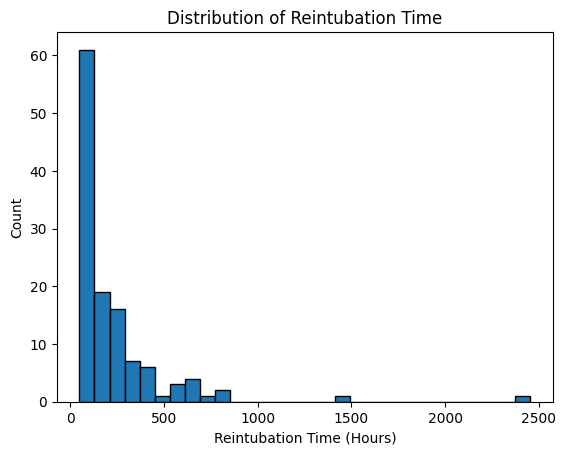

In [148]:
# Plotting the histogram
plt.hist(filtered_df['reintubationtime'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Reintubation Time')
plt.xlabel('Reintubation Time (Hours)')
plt.ylabel('Count')
plt.show()

In [149]:
# Getting descriptive statistics
stats = filtered_df['reintubationtime'].describe()
print(stats)


count     122.000000
mean      228.710656
std       288.932951
min        49.416667
25%        78.066667
50%       129.858333
75%       273.166667
max      2455.333333
Name: reintubationtime, dtype: float64


In [191]:
# 시간차 시각화

# Histogram for Intubation to Death Time Difference
plt.figure(figsize=(10, 5))
plt.hist(filtered_df['intubation_to_death'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Time Difference from Reintubation to Death')
plt.xlabel('Time (Hours)')
plt.ylabel('Count')
plt.show()

# Histogram for Extubation to Death Time Difference
plt.figure(figsize=(10, 5))
plt.hist(filtered_df['extubation_to_death'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Time Difference from Extubation to Death')
plt.xlabel('Time (Hours)')
plt.ylabel('Count')
plt.show()


KeyError: 'intubation_to_death'

<Figure size 1000x500 with 0 Axes>

In [153]:
# Getting descriptive statistics
stats = filtered_df['intubation_to_death'].describe()
print(stats)
print()
stats = filtered_df['extubation_to_death'].describe()
print(stats)


count     122.000000
mean      712.993716
std       743.492092
min       164.283333
25%       351.283333
50%       500.175000
75%       770.258333
max      5962.766667
Name: intubation_to_death, dtype: float64

count     122.000000
mean      614.695902
std       733.340624
min        69.500000
25%       233.129167
50%       391.608333
75%       668.954167
max      5731.900000
Name: extubation_to_death, dtype: float64


In [140]:

# # just for checking if numbers match
# filtered_group = filtered_df.groupby(['subject_id', 'hadm_id'])
# count_group = 0
# for _, group in filtered_group:
#     count_group += 1

# print(count_group)

122


In [ ]:

# Filter the DataFrame
filtered_df = reintubation_df[reintubation_df['subject_id'].isin(subject_ids) & reintubation_df['hadm_id'].isin(hadm_ids)]


-----

In [126]:
reintubation_df[reintubation_df.hadm_id == 22105182]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
8827,19421308,22105182,NaN,2138-08-20 19:01:00,2138-08-20 19:01:00,NaN,NaN,32228914.0,2138-08-27 14:30:00,227194.0,54.5,Planned Extubation,2138-09-08 07:18:00,2138-09-08 07:18:00,NaN,NaN,72.416667
8826,19421308,22105182,32228914.0,2138-08-20 19:01:00,2138-08-30 14:55:00,224385.0,54.5,32228914.0,2138-09-01 07:30:00,227194.0,54.5,Planned Extubation,2138-09-08 07:18:00,2138-09-08 07:18:00,NaN,1 days 16:35:00,0.000000


In [50]:
reintubation_df[reintubation_df.subject_id == 13394692]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
3188,13394692,28720007,NaN,2111-03-13 00:42:00,2111-03-13 00:42:00,NaN,NaN,30434920.0,2111-03-19 12:15:00,227194.0,202.0,Planned Extubation,2111-04-11 16:00:00,NaT,NaN,NaN,13.25


In [43]:
reintubation_df[reintubation_df.extubationcause == 'Planned Extubation']

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1 days 13:10:00,0.000000
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,3 days 18:19:00,0.000000
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,2 days 17:30:00,0.000000
5,10005817,28661809,31316840.0,2135-01-03 21:54:00,2135-01-06 08:33:00,224385.0,88.8,31316840.0,2135-01-19 14:00:00,227194.0,88.8,Planned Extubation,2135-01-19 18:36:00,2135-01-19 18:36:00,NaN,13 days 05:27:00,0.000000
8,10011365,26712576,37153661.0,2166-02-11 14:09:00,2166-02-14 17:59:00,224385.0,46.3,37153661.0,2166-02-14 09:48:00,227194.0,46.3,Planned Extubation,2166-02-20 00:20:00,2166-02-20 00:20:00,intubationtime later than extubationtime,-1 days +15:49:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9416,19997367,20617667,NaN,2126-04-20 07:15:00,2126-04-20 07:15:00,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,NaN,107.850000
9414,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,5 days 20:16:00,73.833333
9415,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2 days 23:09:00,0.000000
9417,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,2 days 22:01:00,0.000000


In [8]:
# test_group = intubation_extubation.groupby(['subject_id', 'hadm_id'])

# modified_groups = []   # 최종 데이터 저장
# group_logs = []   # 로그 저장

# for name, group in test_group:
#     modified_group, log_list = ii.impute_first_intubation(group)
#     modified_groups.append(modified_group)

#     if len(log_list) > 0:
#         group_logs.append(log_list)

# # Recreate the DataFrame with the modifications
# modified_df = pd.concat(modified_groups)
# modified_df

In [6]:
reintubation_df.to_csv('../outputs/reintubationtime.csv')

----

In [11]:
reintubation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9420 entries, 0 to 9419
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   subject_id        9420 non-null   int64         
 1   hadm_id           9420 non-null   int64         
 2   int_stayid        8265 non-null   float64       
 3   admittime         9420 non-null   object        
 4   intubationtime    9149 non-null   datetime64[ns]
 5   int_itemid        8265 non-null   float64       
 6   int_weight        8265 non-null   float64       
 7   ext_stayid        7227 non-null   float64       
 8   extubationtime    7227 non-null   datetime64[ns]
 9   ext_itemid        7227 non-null   float64       
 10  ext_weight        7227 non-null   float64       
 11  extubationcause   7227 non-null   object        
 12  dischtime         9420 non-null   datetime64[ns]
 13  deathtime         2520 non-null   datetime64[ns]
 14  marker            539 non-nul

In [14]:
reintubation_df[reintubation_df.extubationtime.notna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1 days 13:10:00,0.000000
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,3 days 18:19:00,0.000000
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,2 days 17:30:00,0.500000
5,10005817,28661809,31316840.0,2135-01-03 21:54:00,2135-01-06 08:33:00,224385.0,88.8,31316840.0,2135-01-19 14:00:00,227194.0,88.8,Planned Extubation,2135-01-19 18:36:00,2135-01-19 18:36:00,NaN,13 days 05:27:00,0.000000
8,10011365,26712576,37153661.0,2166-02-11 14:09:00,2166-02-14 17:59:00,224385.0,46.3,37153661.0,2166-02-14 09:48:00,227194.0,46.3,Planned Extubation,2166-02-20 00:20:00,2166-02-20 00:20:00,intubationtime later than extubationtime,-1 days +15:49:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9416,19997367,20617667,NaN,2126-04-20 07:15:00,2126-04-20 07:15:00,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,NaN,107.850000
9414,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,5 days 20:16:00,73.833333
9415,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2 days 23:09:00,0.000000
9417,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,2 days 22:01:00,0.000000


In [12]:
# 2024 1 24 할 것 군집 분류 코딩 --> 카운트

reintubation_df

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,int_ext_timediff,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1 days 13:10:00,0.000000
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,3 days 18:19:00,0.000000
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,NaN,0.000000
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,2 days 17:30:00,0.500000
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9414,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,5 days 20:16:00,73.833333
9415,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2 days 23:09:00,0.000000
9417,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,2 days 22:01:00,0.000000
9418,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,0 days 19:15:00,0.000000


In [1]:
reintubation_df[reintubation_df.subject_id == 10136619]

NameError: name 'reintubation_df' is not defined